In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import string
import nltk
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

In [4]:
# Ensure you have the necessary nltk resources
nltk.download('stopwords')

# Load the datasets
train_csv_file_path = 'bugs-train.csv'  # Update this with your actual file path
test_csv_file_path = 'bugs-test.csv'    # Update this with your actual file path

train_df = pd.read_csv(train_csv_file_path)
test_df = pd.read_csv(test_csv_file_path)

# Display the first few rows of the training dataset
print("First few rows of the training dataset:")
print(train_df.head())

# Check for class imbalance in the training set
severity_counts = train_df['severity'].value_counts()
print("\nDistribution of Bug Severity in Training Set:")
print(severity_counts)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


First few rows of the training dataset:
   bug_id                                            summary  severity
0  365569                  Remove workaround from bug 297227    normal
1  365578    Print Preview crashes on any URL in gtk2 builds  critical
2  365582                     Lines are not showing in table     major
3  365584  Firefox render ÛÏsimplified ArabicÛ font fa...    normal
4  365597             Crash [@ nsINodeInfo::NodeInfoManager]  critical

Distribution of Bug Severity in Training Set:
severity
normal         67578
critical       12168
major           4728
enhancement     3216
minor           2485
trivial          984
blocker          407
Name: count, dtype: int64


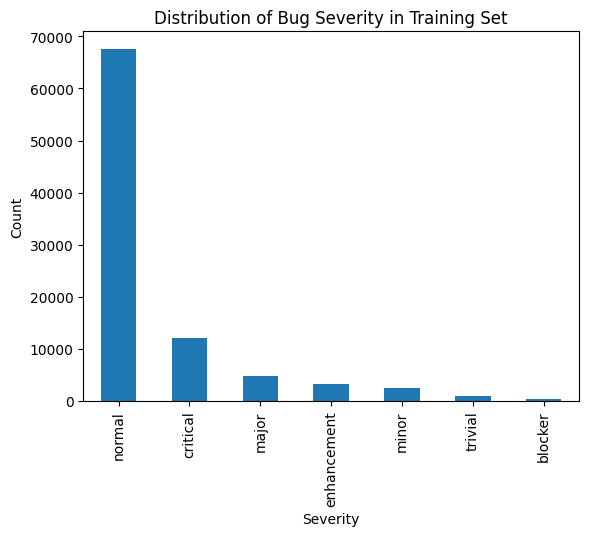

In [5]:

# Plot the distribution of bug severity in the training set
severity_counts.plot(kind='bar')
plt.xlabel('Severity')
plt.ylabel('Count')
plt.title('Distribution of Bug Severity in Training Set')
plt.show()

In [6]:
# Define text preprocessing function
def preprocess_text(text):
    stemmer = SnowballStemmer("english")
    stop_words = set(stopwords.words("english"))
    text = text.lower()
    text = "".join([char for char in text if char not in string.punctuation])
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [stemmer.stem(word) for word in tokens]
    return " ".join(tokens)

In [8]:
# Identify and replace corrupted characters manually
def clean_text(text):
    replacements = {
        'ÛÏ': '"',
        'Û': '"',
        # Add other replacements as needed
    }
    for corrupt, correct in replacements.items():
        text = text.replace(corrupt, correct)
    return text

In [11]:

# Apply the preprocessing function to the training and testing datasets
train_df['processed_summary'] = train_df['summary'].apply(clean_text).apply(preprocess_text)
test_df['processed_summary'] = test_df['summary'].apply(clean_text).apply(preprocess_text)

# Convert text to numerical features using TF-IDF
tfidf = TfidfVectorizer(max_features=1000)
X_train = tfidf.fit_transform(train_df['processed_summary'])
X_test = tfidf.transform(test_df['processed_summary'])

# Use the 'severity' column as the target variable for training and ensure all values are strings
y_train = train_df['severity'].astype(str)

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

ValueError: Expected n_neighbors <= n_samples,  but n_samples = 1, n_neighbors = 6

In [ ]:

# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the Random Forest model
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Initialize RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=50, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Train the model with RandomizedSearchCV
rf_random.fit(X_train_res, y_train_res)

# Making predictions on the training set
y_train_pred = rf_random.predict(X_train)

# Evaluating the model on the training set
print("\nTraining Set Classification Report:")
print(classification_report(y_train, y_train_pred))

# Making predictions on the test set
test_df['severity'] = rf_random.predict(X_test)

# Preparing the submission file
submission_df = test_df[['bug_id', 'severity']]
submission_df.to_csv('bug_severity_predictions.csv', index=False)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


First few rows of the training dataset:
   bug_id                                            summary  severity
0  365569                  Remove workaround from bug 297227    normal
1  365578    Print Preview crashes on any URL in gtk2 builds  critical
2  365582                     Lines are not showing in table     major
3  365584  Firefox render ÛÏsimplified ArabicÛ font fa...    normal
4  365597             Crash [@ nsINodeInfo::NodeInfoManager]  critical

Distribution of Bug Severity in Training Set:
severity
normal         125854
critical        18658
major            6053
enhancement      4426
minor            3102
trivial          1204
blocker           701
Name: count, dtype: int64


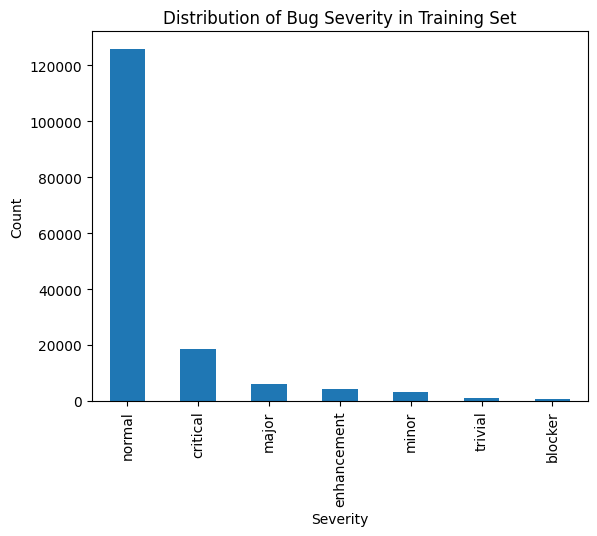


Training Set Classification Report:
              precision    recall  f1-score   support

     blocker       0.43      0.91      0.58       701
    critical       0.86      0.96      0.91     18658
 enhancement       0.60      0.93      0.73      4426
       major       0.83      0.95      0.89      6053
       minor       0.62      0.93      0.74      3102
      normal       1.00      0.89      0.94    125854
     trivial       0.16      0.98      0.27      1204

    accuracy                           0.90    159998
   macro avg       0.64      0.94      0.72    159998
weighted avg       0.95      0.90      0.92    159998



NameError: name 'tools' is not defined

In [ ]:






# Apply the preprocessing function to the training and testing datasets
train_df['processed_summary'] = train_df['summary'].apply(preprocess_text)
test_df['processed_summary'] = test_df['summary'].apply(preprocess_text)

# Convert text to numerical features using TF-IDF
tfidf = TfidfVectorizer(max_features=1000)
X_train = tfidf.fit_transform(train_df['processed_summary'])
X_test = tfidf.transform(test_df['processed_summary'])

# Use the 'severity' column as the target variable for training
y_train = train_df['severity']

# Training the model with class weights to handle imbalance
model = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Making predictions on the training set
y_train_pred = model.predict(X_train)

# Evaluating the model on the training set
print("\nTraining Set Classification Report:")
print(classification_report(y_train, y_train_pred))

# Making predictions on the test set
test_df['severity'] = model.predict(X_test)

# Preparing the submission file
submission_df = test_df[['bug_id', 'severity']]
submission_df.to_csv('bug_severity_predictions.csv', index=False)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


First few rows of the training dataset:
   bug_id                                            summary  severity
0  365569                  Remove workaround from bug 297227    normal
1  365578    Print Preview crashes on any URL in gtk2 builds  critical
2  365582                     Lines are not showing in table     major
3  365584  Firefox render ÛÏsimplified ArabicÛ font fa...    normal
4  365597             Crash [@ nsINodeInfo::NodeInfoManager]  critical

Distribution of Bug Severity in Training Set:
severity
normal         125854
critical        18658
major            6053
enhancement      4426
minor            3102
trivial          1204
blocker           701
Name: count, dtype: int64


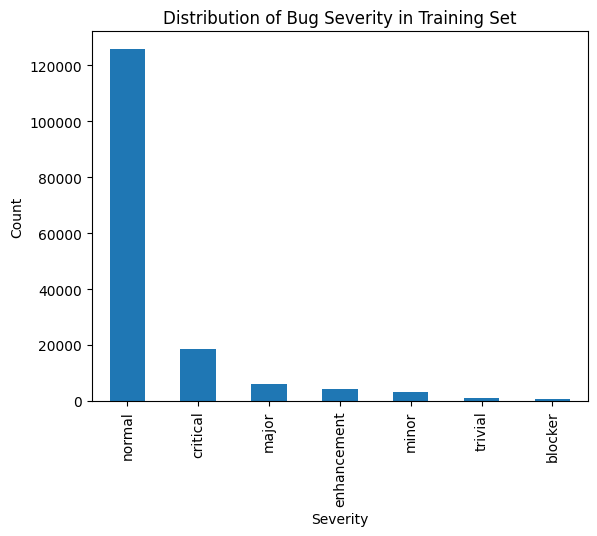

Fitting 3 folds for each of 50 candidates, totalling 150 fits


In [ ]:


# Ensure you have the necessary nltk resources
nltk.download('stopwords')

# Load the datasets
train_csv_file_path = 'bugs-train.csv'  # Update this with your actual file path
test_csv_file_path = 'bugs-test.csv'    # Update this with your actual file path

train_df = pd.read_csv(train_csv_file_path)
test_df = pd.read_csv(test_csv_file_path)

# Display the first few rows of the training dataset
print("First few rows of the training dataset:")
print(train_df.head())

# Check for class imbalance in the training set
severity_counts = train_df['severity'].value_counts()
print("\nDistribution of Bug Severity in Training Set:")
print(severity_counts)

# Plot the distribution of bug severity in the training set
severity_counts.plot(kind='bar')
plt.xlabel('Severity')
plt.ylabel('Count')
plt.title('Distribution of Bug Severity in Training Set')
plt.show()






In [ ]:
test_df = pd.read_csv("bugs-train.csv",encoding='latin1')
test_df.head()

,bug_id,summary,severity
0,365569,Remove workaround from bug 297227,normal
1,365578,Print Preview crashes on any URL in gtk2 builds,critical
2,365582,Lines are not showing in table,major
3,365584,Firefox render ÂÃÃsimplified ArabicÂÃÂ f...,normal
4,365597,Crash [@ nsINodeInfo::NodeInfoManager],critical
